# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 5):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0


For convenience, we concatenate all important commands into one, delete when done.

### 4. Setting up the Agent

We will set up an MADDPG agent:

In [7]:
from maddpg import MADDPG_Agent
seed=0

num_agents = 2
agent = MADDPG_Agent(state_size, action_size, num_agents, seed=seed)

In case there is already a weight file available from previous training runs, then we can load it via this function call:

In [8]:
filename_root = 'checkpoint_final'
agent.load_weights(filename_root)

### 5. Training
In case no agent weights have been loaded, we need to train our agent.

In [8]:
from collections import deque
import time
            
def maddpg(n_episodes=2000):
    """DDPG for solving reacher environment.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    scores = []                         # List containing scores from each episode
    moving_avgs = []                    # List containing the moving average
    WINDOW_SIZE=100                     # Window relevant for solving the environment
    scores_window = deque(maxlen=WINDOW_SIZE)   # Last 100 scores
    best_score = -np.inf                # For the absolute max value ever reached
    THRESH_SOLVED = 0.5                 # When is the environment considered solved?
    solved = False                      # To keep track whether we already solved the environment
    aggregate_output = WINDOW_SIZE      # Number of episodes to display in one changing line
    save_checkpoint = 10*WINDOW_SIZE    # Save checkpoints to avoid big clashes in case workspace freezes.
    
    NOISE_START = 6                     # Scaling factor for noise at start
    NOISE_END = 0                       # Leave a little noise for exploration also at the end
    NOISE_DECAY_U_PER = 500             # Time until noise reduction is finished
    
    BETA_START = 0                      # PER: Start value for beta
    BETA_END = 1                        # PER: End value for beta
    BETA_DECAY_U_PER = 2000             # Until which episode to reach BETA_END

    # Beta controls the importance weights. (0-no importance weights, 1-completely according to importance weights)
    # In the beginning, we don't know which experiences are important, so just ignore.
    # Later on, we want to sample more and more experiences out of the ones 
    #       we think are important, so increase beta over time.
    beta_schedule = \
            lambda episode: min(BETA_END, \
                BETA_START + episode*(BETA_END - BETA_START)/BETA_DECAY_U_PER)
    
    # Action space noise: reduce to zero over time.
    noise_schedule = \
            lambda episode: max(NOISE_END, \
                NOISE_START - episode*(NOISE_START - NOISE_END)/NOISE_DECAY_U_PER)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]   # Reset the environment to train mode
        states = env_info.vector_observations               # Get initial state
        score = np.zeros(num_agents)                        # Reset scores
        noise_cur = noise_schedule(i_episode)               # Reduction of noise 
        beta_cur = beta_schedule(i_episode)                 # Increase of beta
        
        # Reset noises
        agent.reset()
        
        # Keep track of the time
        if (i_episode - 1) % aggregate_output == 0:
            start_time = time.time()
        
        while True: 
            # actions = agent.act(states, noise=noise_cur)    # Get action from actor
            actions = agent.act(states, noise_cur)
            env_info = env.step(actions)[brain_name]        # Send action to the environment
            next_states = env_info.vector_observations      # Get the next state, ...
            rewards = env_info.rewards                      # ..., reward ...
            dones = env_info.local_done                     # ..., and whether the episode has finished
            done = any(dones)                             # We're done if any of the agent fails

            # Take one step, learn new weights via soft update
            agent.step(states, actions, rewards, next_states, done, beta_cur) 
            states = next_states                            # Progress states 
            score += rewards                                # Update score
            
            if np.any(dones):
                break
        # Track timing and progress
        duration = time.time() - start_time
        scores.append(max(score))                           # Save most recent score
        scores_window.append(scores[-1])                    # Save most recent score
        moving_avgs.append(np.mean(scores_window))
        
        # If we were better than the highscore, save model
        if max(score)>best_score and max(score)>THRESH_SOLVED:
            best_score = scores[-1]
            filename=filename_root+f"_e{i_episode}_s{best_score:.3f}"
            agent.save(filename)
            print(f"\nNew highscore: \t{scores[-1]}\tBacked up model.")
        
        # Display some progress
        print(f"\rEpisode {i_episode} ({duration:.1f}s)"\
              f"\tAverage Max Score: {moving_avgs[-1]:.4f}, "\
              f"Best of last 10 runs: {np.max(scores[-10:]):.4f}", end="")
        if i_episode % aggregate_output == 0:
            print(f"\rEpisode {i_episode} ({duration:.1f}s)"\
                  f"\tAverage Max Score: {moving_avgs[-1]:.4f}, "\
                  f"Best of last 10 runs: {np.max(scores[-10:]):.4f}")
        # Save model from time to time
        if i_episode % save_checkpoint == 0:
            filename = filename_root+f"_e{i_episode}"
            agent.save(filename)
            print("Backed up model.\n")
        
        # Only print "solved" if target score reached for the first time
        if moving_avgs[-1] >= THRESH_SOLVED and i_episode>= WINDOW_SIZE and not solved:    
            print(f"\nEnvironment solved in {i_episode - WINDOW_SIZE:d} episodes!"\
                  f"\tAverage Max Score: {moving_avgs[-1]:.4f}, All-time best: {best_score:.4f}")
            filename = filename_root+f"_solved_e{i_episode-WINDOW_SIZE}"
            agent.save(filename)
            solved = True
            # Give the user the possibility to cancel further training
            answer = input("Should I continue training? [Y/n]")  
            if answer.lower()=='n':
                break
    return scores, moving_avgs

filename_root = 'checkpoint'
# Train agent and keep track of the scores
if 'scores_tot' in locals():
    # Append if scores already exist, adjust epsilon to final value
    print(f"Continue training after having already trained for {len(scores_tot)} episodes.\n")
    new_scores, new_moving_avgs = maddpg(n_episodes=300) 
    scores_tot = np.append(scores_tot,new_scores)
    moving_avgs_tot = np.append(moving_avgs_tot,new_moving_avgs)
else: 
    # No scores have been generated, so start training all over, again
    scores_tot, moving_avgs_tot = maddpg()

Episode 100 (76.2s)	Average Max Score: 0.0066, Best of last 10 runs: 0.0900
Episode 200 (93.3s)	Average Max Score: 0.0106, Best of last 10 runs: 0.0000
Episode 300 (108.0s)	Average Max Score: 0.0160, Best of last 10 runs: 0.0900
Episode 400 (163.5s)	Average Max Score: 0.0560, Best of last 10 runs: 0.1000
Episode 500 (253.8s)	Average Max Score: 0.0981, Best of last 10 runs: 0.2900
Episode 538 (111.2s)	Average Max Score: 0.1056, Best of last 10 runs: 0.3000
New highscore: 	1.0000000149011612	Backed up model.
Episode 600 (405.6s)	Average Max Score: 0.1601, Best of last 10 runs: 0.3000
Episode 700 (335.7s)	Average Max Score: 0.1337, Best of last 10 runs: 0.4000
Episode 722 (91.5s)	Average Max Score: 0.1413, Best of last 10 runs: 0.5000
New highscore: 	1.700000025331974	Backed up model.
Episode 756 (327.4s)	Average Max Score: 0.2011, Best of last 10 runs: 1.6000
New highscore: 	2.500000037252903	Backed up model.
Episode 770 (515.0s)	Average Max Score: 0.2469, Best of last 10 runs: 1.0900
Ne

When we are finished, we can back up our model:

In [9]:
filename_root = "checkpoint_final"
agent.save(filename_root)

### 6. Visualization 

When we're done, we can visualize our results.

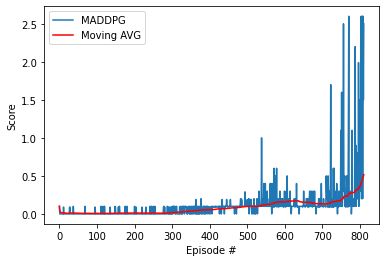

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(scores_tot)), scores_tot, label='MADDPG')
plt.plot(np.arange(len(scores_tot)), moving_avgs_tot, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

Check how a trained model behaves.

In [9]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, noise=0.0)    # Get action from actor
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print(f"Score (max over agents) in episode {i}: {np.max(scores)}")

Score (max over agents) in episode 4: 1.600000023841858


When finished, we should close the environment.

In [10]:
env.close()